环境设置——导入必要的库

In [ ]:
# 基础库
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import matplotlib.font_manager as fm 
import seaborn as sns 
import yfinance as yf
import ccxt  
from datetime import datetime, timedelta 


# 设置绘图样式
plt.style.use('seaborn-v0_8') 
plt.rcParams['figure.figsize'] = (14, 7) 
plt.rcParams['font.size'] = 12  

# 显示所有列、行
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', 1000)
pd.set_option('display.unicode.ambiguous_as_wide' , True)
pd.set_option('display.unicode.east_asian_width', True)

获取市场数据——美股yfinance ,虚拟币数据从binance获取

In [16]:
import time
import pandas as pd
from datetime import timedelta
import ccxt

# 初始化币安客户端
BINANCE_CONFIG = {
    # 'proxies': {'http': 'http://127.0.0.1:7890', 'https': 'https://127.0.0.1:7890'}
}
exchange = ccxt.binance(BINANCE_CONFIG)

# 参数设置
symbol = 'BTCUSDT'
time_interval = '1d'  # 时间间隔
bar_num = 1000  # 每次请求的最大K线数量

# 计算起始时间和结束时间
end_time = int(time.time() * 1000)  # 当前时间戳（毫秒）
start_time = end_time - 3 * 365 * 24 * 60 * 60 * 1000  # 三年前的时间戳（毫秒）

# 存储所有数据的列表
all_data = []

# 分批次获取数据
while start_time < end_time:
    params = {
        'symbol': symbol,
        'interval': time_interval,
        'startTime': start_time,
        'endTime': end_time,
        'limit': bar_num
    }
    response = exchange.fapiPublicGetKlines(params=params)
    all_data.extend(response)  # 将数据添加到列表中

    # 更新起始时间，为下一次请求做准备
    if len(response) > 0:
        start_time = int(response[-1][0]) + 1  # 将字符串转换为整数，然后 +1 毫秒
    else:
        break

# 将数据转换为 DataFrame
df = pd.DataFrame(all_data, dtype=float)
df.rename(columns={0: 'MTS', 1: 'open', 2: 'high',
                   3: 'low', 4: 'close', 5: 'volume'}, inplace=True)

# 整理时间
df['candle_begin_time'] = pd.to_datetime(df['MTS'], unit='ms')
df['candle_begin_time_GMT8'] = df['candle_begin_time'] + timedelta(hours=8)  # 转换为北京时间

# 整理列的顺序
df = df[['candle_begin_time_GMT8', 'open', 'high', 'low', 'close', 'volume']]

# 输出数据
print(df.tail())

#保存为csv文件
df.to_csv(f"{symbol}_past_year_stock_data.csv") 
print(f"{symbol} past 3 year stock data downloaded and saved to CSV file.

     candle_begin_time_GMT8     open     high      low    close      volume
1090    2025-03-14 08:00:00  81085.5  85270.2  80772.0  83939.8  233544.708
1091    2025-03-15 08:00:00  83939.9  84625.0  83564.5  84302.9   76674.970
1092    2025-03-16 08:00:00  84303.0  85136.0  81925.6  82541.6  174630.700
1093    2025-03-17 08:00:00  82541.6  84727.1  82384.0  83962.9  182662.082
1094    2025-03-18 08:00:00  83963.0  83979.8  82207.7  82492.7   41873.206


数据探索与可视化

In [18]:
# 查看数据基本信息
print("数据形状:", df.shape)  
print("\n数据类型:")  
print(df.dtypes)  
print("\n基本统计信息:")  
df.describe()

数据形状: (1095, 6)

数据类型:
candle_begin_time_GMT8    datetime64[ns]
open                             float64
high                             float64
low                              float64
close                            float64
volume                           float64
dtype: object

基本统计信息:


,open,high,low,close,volume
count,1095.000000,1095.000000,1095.000000,1095.000000,1.095000e+03
mean,44777.357078,45705.291050,43837.087580,44814.164566,3.823253e+05
std,24926.975064,25453.892113,24365.810418,24952.892439,2.535085e+05
min,15772.900000,16304.300000,15443.200000,15773.000000,4.187321e+04
25%,24659.650000,25318.800000,24164.700000,24659.700000,2.142237e+05
50%,35406.500000,35981.900000,34520.300000,35406.500000,3.153139e+05
75%,63501.750000,64712.400000,62309.500000,63652.900000,4.806401e+05
max,106115.400000,110000.000000,105252.000000,106114.500000,2.065606e+06


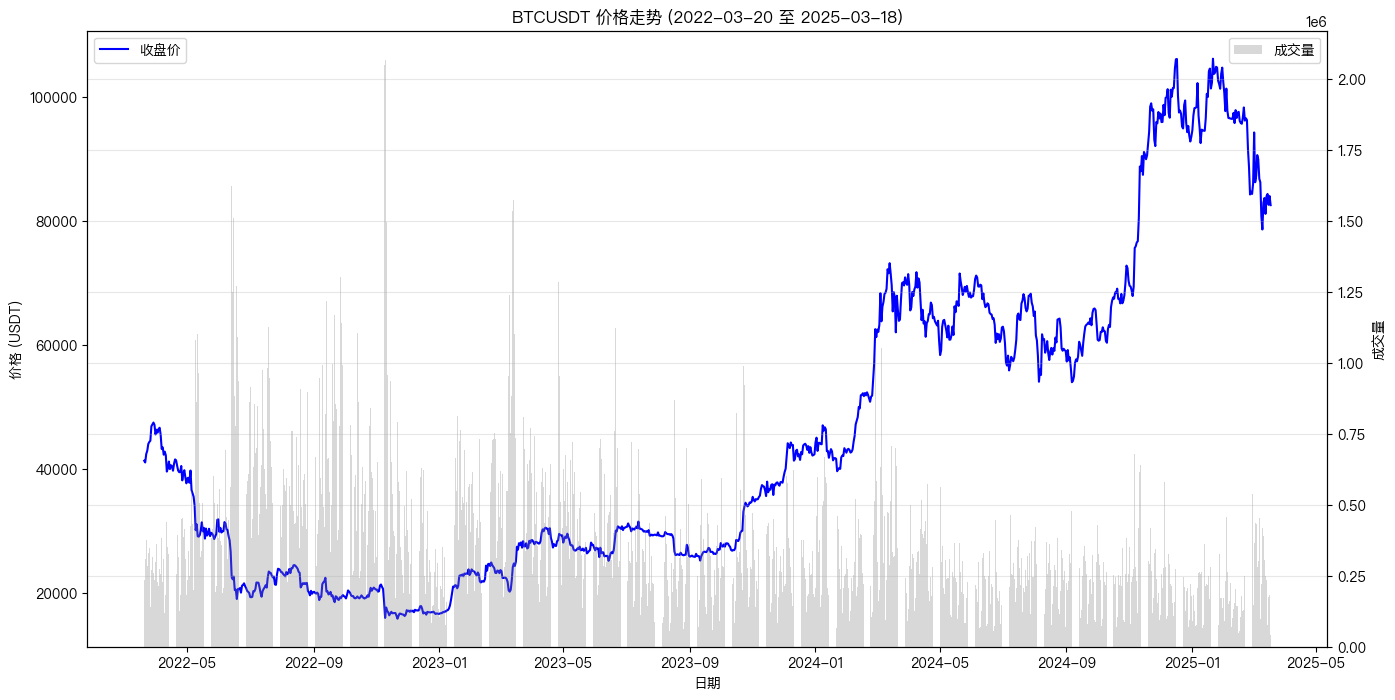

In [19]:
import matplotlib.pyplot as plt

# 设置字体和负号显示
plt.rcParams['font.sans-serif'] = ['PingFang HK']  # 设置字体为 PingFang HK
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 获取起始日期和结束日期
start_date = df['candle_begin_time_GMT8'].iloc[0]  # 获取数据的第一行时间
end_date = df['candle_begin_time_GMT8'].iloc[-1]  # 获取数据的最后一行时间

# 创建画布
plt.figure(figsize=(16, 8))

# 绘制收盘价
plt.plot(df['candle_begin_time_GMT8'], df['close'], label='收盘价', color='blue')

# 创建双轴
ax1 = plt.gca()  # 获取当前轴
ax2 = ax1.twinx()  # 创建第二个 y 轴

# 绘制成交量
ax2.bar(df['candle_begin_time_GMT8'], df['volume'], alpha=0.3, color='gray', label='成交量')

# 设置标题和标签
plt.title(f'{symbol} 价格走势 ({start_date.date()} 至 {end_date.date()})')  # 设置标题
ax1.set_xlabel('日期')  # 设置 x 轴标签
ax1.set_ylabel('价格 (USDT)')  # 设置第一个 y 轴标签
ax2.set_ylabel('成交量')  # 设置第二个 y 轴标签

# 添加图例
ax1.legend(loc='upper left')  # 第一个 y 轴的图例
ax2.legend(loc='upper right')  # 第二个 y 轴的图例

# 显示网格
plt.grid(True, alpha=0.3)

# 显示图表
plt.show()

计算技术指标——价格指数部分

In [22]:
# 计算移动平均线
df['SMA20'] = df['close'].rolling(window=20).mean()  # 20日简单移动平均线  
df['SMA50'] = df['close'].rolling(window=50).mean()  # 50日简单移动平均线  
df['SMA200'] = df['close'].rolling(window=200).mean()  # 200日简单移动平均线  

# 计算相对强弱指数 (RSI)
period=14 
delta = df['close'].diff()  
# 分离涨跌幅
gain = delta.clip(lower=0)         # 涨幅为正，其余为0  
loss = -delta.clip(upper=0)        # 跌幅取绝对值，其余为0
# 使用 Wilder 平滑：alpha=1/period，min_periods=period，adjust=False
avg_gain = gain.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
avg_loss = loss.ewm(alpha=1/period, min_periods=period, adjust=False).mean() # 计算RS及RSI
rs = avg_gain / avg_loss 
rsi = 100 - (100 / (1 + rs)) 
df['RSI14'] = rsi  

# 计算布林带
rolling_std = df['close'].rolling(window=20).std()  
df['BB_middle'] = df['close'].rolling(window=20).mean()  
df['BB_upper'] = df['BB_middle'] + (rolling_std * 2)  
df['BB_lower'] = df['BB_middle'] - (rolling_std * 2)  

# 计算MACD指标
df['EMA12'] = df['close'].ewm(span=12, adjust=False).mean()  # 12日指数移动平均线  
df['EMA26'] = df['close'].ewm(span=26, adjust=False).mean()  # 26日指数移动平均线  
df['DIF'] = df['EMA12'] - df['EMA26']  # DIF线  
df['DEA'] = df['DIF'].ewm(span=9, adjust=False).mean()  # DEA线  
df['MACD'] = (df['DIF'] - df['DEA']) * 2  # MACD柱状图 

# 显示带有技术指标的数据
df.tail()  

,candle_begin_time_GMT8,open,high,low,close,volume,SMA20,SMA50,SMA200,RSI14,BB_middle,BB_upper,BB_lower,EMA12,EMA26,DIF,DEA,MACD
1090,2025-03-14 08:00:00,81085.5,85270.2,80772.0,83939.8,233544.708,86371.410,93811.380,83729.1090,43.568591,86371.410,95312.408386,77430.411614,84579.509962,87884.629024,-3305.119062,-3176.324392,-257.589339
1091,2025-03-15 08:00:00,83939.9,84625.0,83564.5,84302.9,76674.970,85775.635,93401.276,83853.7010,44.197830,85775.635,93452.510217,78098.759783,84536.954583,87619.315763,-3082.361179,-3157.531750,150.341140
1092,2025-03-16 08:00:00,84303.0,85136.0,81925.6,82541.6,174630.700,85326.990,92958.068,83971.3590,41.765069,85326.990,92631.454768,78022.525232,84229.976955,87243.188669,-3013.211714,-3128.667743,230.912057
1093,2025-03-17 08:00:00,82541.6,84727.1,82384.0,83962.9,182662.082,85093.180,92586.124,84094.5575,44.423508,85093.180,92249.105817,77937.254183,84188.888193,87000.204323,-2811.316131,-3065.197420,507.762579
1094,2025-03-18 08:00:00,83963.0,83979.8,82207.7,82492.7,41873.206,85007.390,92195.552,84211.5395,42.273751,85007.390,92248.605251,77766.174749,83927.936163,86666.315114,-2738.378951,-2999.833726,522.909550


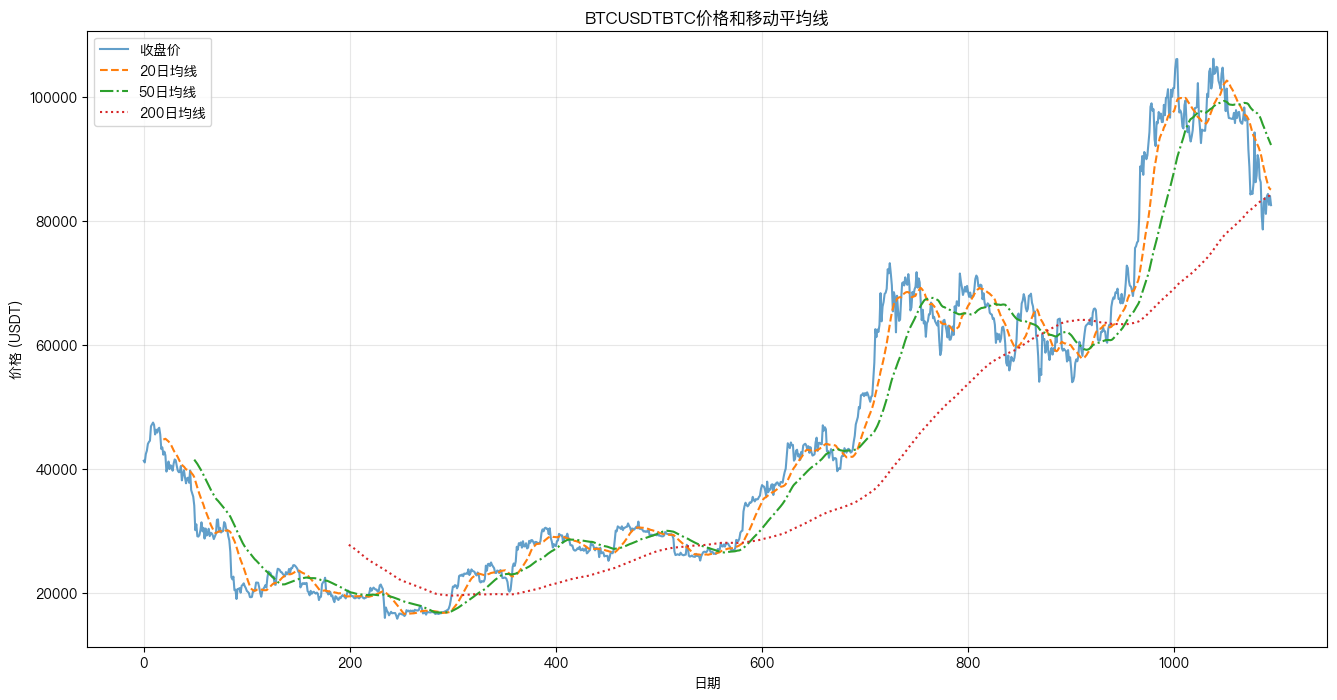

In [25]:
#绘制移动平均线图
plt.figure(figsize=(16, 8))  
plt.plot(df.index, df['close'], label='收盘价', alpha=0.7)  
plt.plot(df.index, df['SMA20'], label='20日均线', linestyle='--') 
plt.plot(df.index, df['SMA50'], label='50日均线', linestyle='-.') 
plt.plot(df.index, df['SMA200'], label='200日均线', linestyle=':') 

plt.title(f'{symbol}BTC价格和移动平均线') 
plt.xlabel('日期')
plt.ylabel('价格 (USDT)') 
plt.legend()
plt.grid(True, alpha=0.3)
plt.show() 


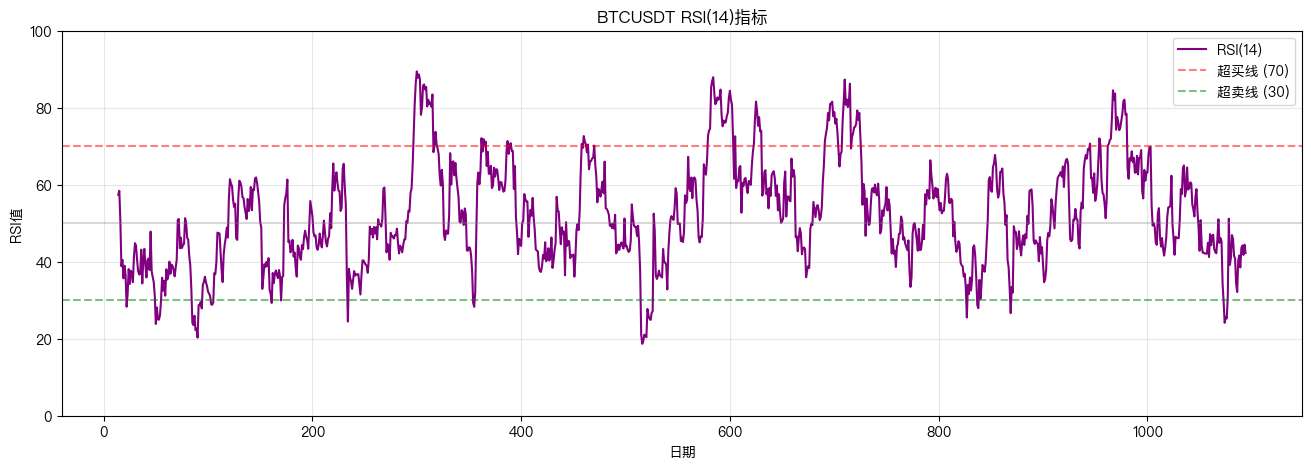

In [26]:
# 绘制RSI指标
plt.figure(figsize=(16, 5)) 
plt.plot(df.index, df['RSI14'], label='RSI(14)', color='purple')  

# 添加超买超卖区域
plt.axhline(y=70, color='r', linestyle='--', alpha=0.5, label='超买线 (70)')  
plt.axhline(y=30, color='g', linestyle='--', alpha=0.5, label='超卖线 (30)')  
plt.axhline(y=50, color='gray', linestyle='-', alpha=0.3)  

plt.title(f'{symbol} RSI(14)指标') 
plt.xlabel('日期') 
plt.ylabel('RSI值')  
plt.legend() 
plt.grid(True, alpha=0.3)  
plt.ylim(0, 100) 
plt.show()  

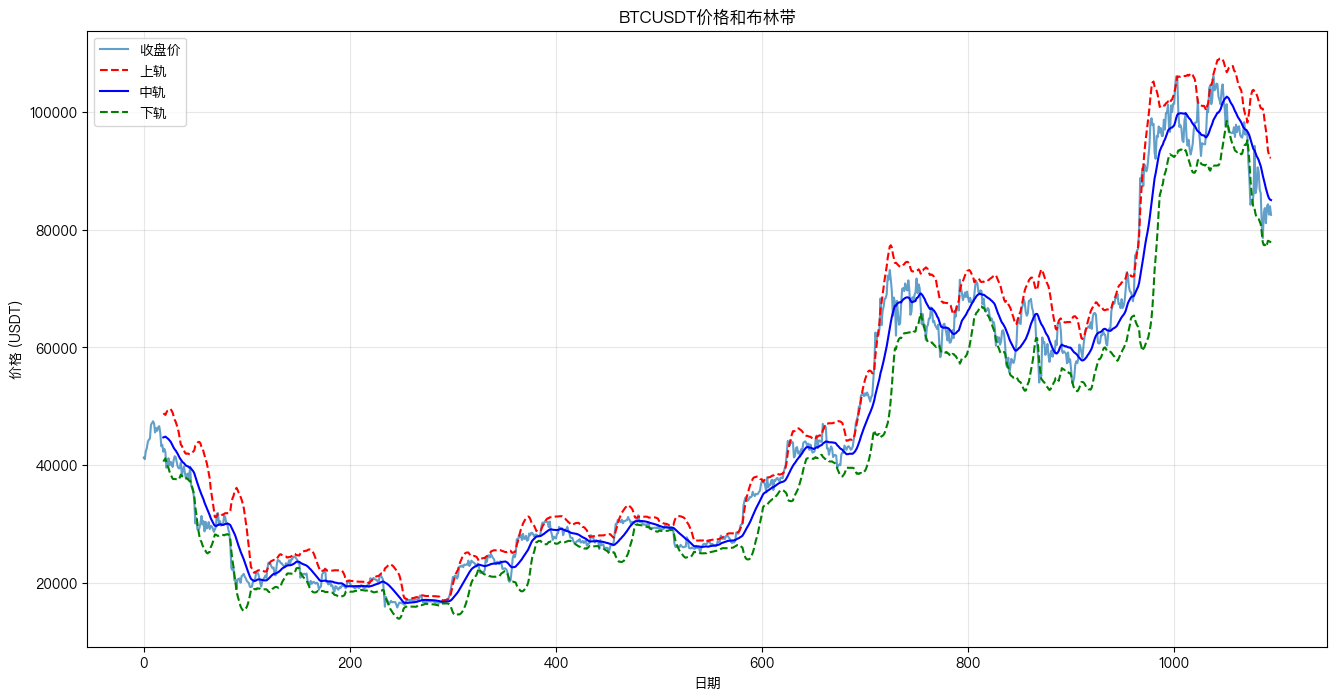

In [28]:
# 绘制布林带
plt.figure(figsize=(16, 8))  
plt.plot(df.index, df['close'], label='收盘价', alpha=0.7)  
plt.plot(df.index, df['BB_upper'], label='上轨', color='red', linestyle='--')  
plt.plot(df.index, df['BB_middle'], label='中轨', color='blue', linestyle='-')  
plt.plot(df.index, df['BB_lower'], label='下轨', color='green', linestyle='--')  

plt.title(f'{symbol}价格和布林带')  
plt.xlabel('日期') 
plt.ylabel('价格 (USDT)') 
plt.legend() 
plt.grid(True, alpha=0.3)  
plt.show() 


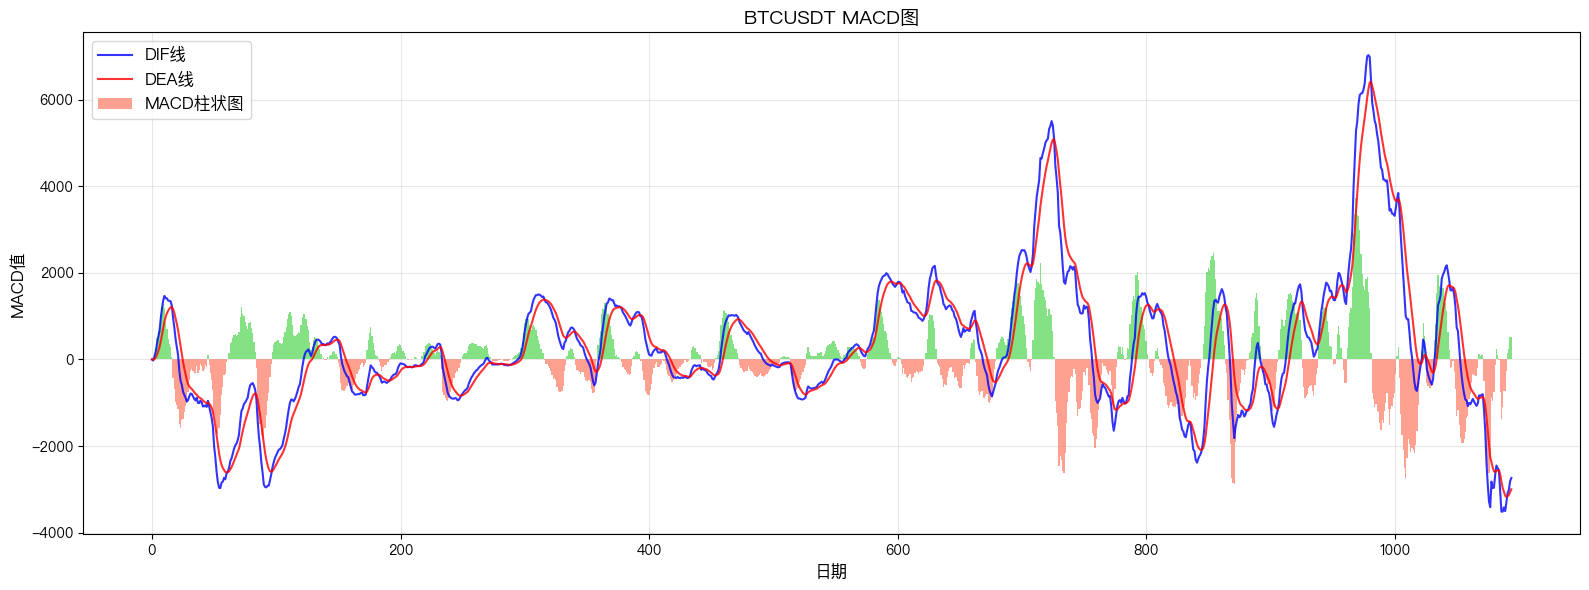

In [30]:
# 创建画布
plt.figure(figsize=(16, 6))

# 绘制DIF线
plt.plot(df.index, df['DIF'], label='DIF线', color='blue', linestyle='-', linewidth=1.5, alpha=0.8)

# 绘制DEA线
plt.plot(df.index, df['DEA'], label='DEA线', color='red', linestyle='-', linewidth=1.5, alpha=0.8)

# 绘制MACD柱状图
plt.bar(df.index, df['MACD'], label='MACD柱状图', color=np.where(df['MACD'] > 0, 'limegreen', 'tomato'), alpha=0.6, width=1)

# 设置标题和标签
plt.title(f'{symbol} MACD图', fontsize=14, fontweight='bold')
plt.xlabel('日期', fontsize=12)
plt.ylabel('MACD值', fontsize=12)

# 设置图例
plt.legend(loc='upper left', fontsize=12)

# 设置网格线
plt.grid(True, alpha=0.3)

# 调整布局
plt.tight_layout()
plt.show()

均线平均线策略（SMA20，SMA50）
根据均线交叉生成原始信号：20日均线大于50日均线时信号为1（买入），反之为-1（卖出）

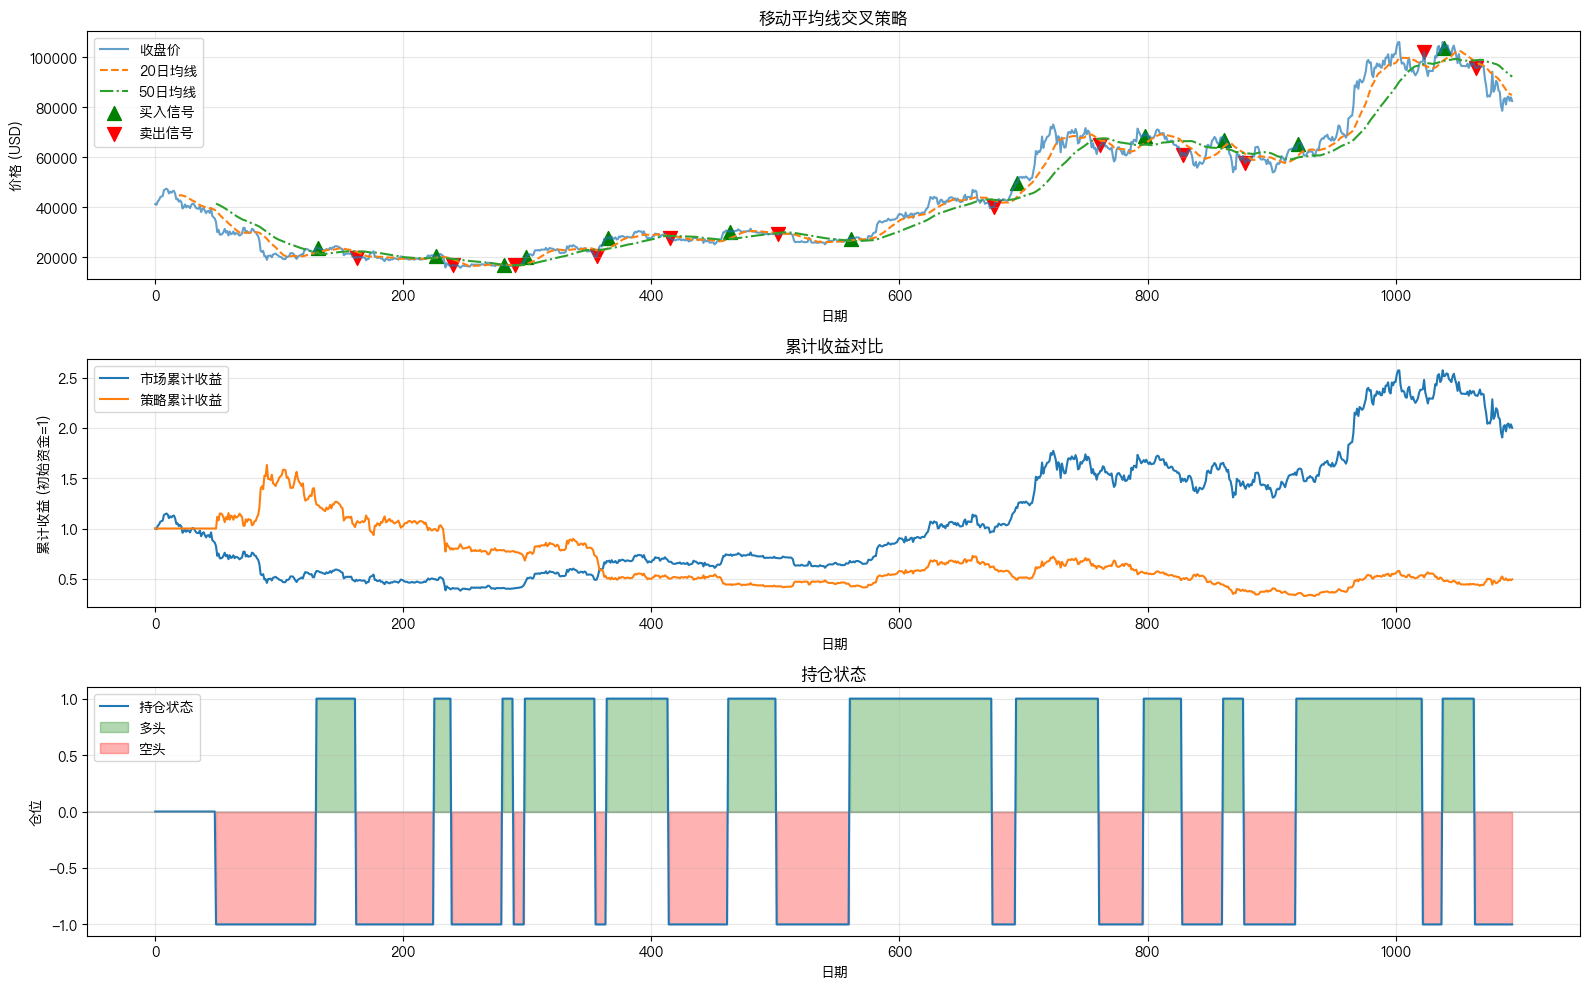

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# 计算短期（20日）和长期（50日）移动平均线
df['SMA_Fast'] = df['close'].rolling(window=20).mean()
df['SMA_Slow'] = df['close'].rolling(window=50).mean()

# 根据均线交叉生成原始信号：20日均线大于50日均线时信号为1（买入），反之为-1（卖出）
df['Signal'] = 0
df.loc[df['SMA_Fast'] > df['SMA_Slow'], 'Signal'] = 1
df.loc[df['SMA_Fast'] < df['SMA_Slow'], 'Signal'] = -1

# 将信号延迟一天，模拟“下一日开盘”交易
df['Trade_Signal'] = df['Signal'].shift(1)

# 计算市场的日收益率（基于收盘价的百分比变化）
df['Market_Return'] = df['close'].pct_change()

# 计算仓位变化（买卖时仓位的变化会产生交易成本）
df['Position_Change'] = df['Trade_Signal'].diff().abs()

# 设置交易成本比例（例如：每次交易成本为0.1%）
transaction_cost = 0.00095

# 计算策略的日收益率：使用前一日的交易信号乘以当天市场收益，同时扣除因仓位变动产生的交易费用
df['Strategy_Return'] = df['Trade_Signal'] * df['Market_Return'] - transaction_cost * df['Position_Change']

# 计算累计收益，初始资金设为1
df['Cumulative_Market'] = (1 + df['Market_Return'].fillna(0)).cumprod()
df['Cumulative_Strategy'] = (1 + df['Strategy_Return'].fillna(0)).cumprod()

# 绘制结果
plt.figure(figsize=(16, 10))

# 子图1：收盘价、均线及买卖信号标记
plt.subplot(3, 1, 1)
plt.plot(df.index, df['close'], label='收盘价', alpha=0.7)
plt.plot(df.index, df['SMA_Fast'], label='20日均线', linestyle='--')
plt.plot(df.index, df['SMA_Slow'], label='50日均线', linestyle='-.')
df['Trade_Change'] = df['Trade_Signal'].diff()
buy_signals = df[df['Trade_Change'] == 2].index
sell_signals = df[df['Trade_Change'] == -2].index
plt.scatter(buy_signals, df.loc[buy_signals, 'close'], marker='^', color='g', s=100, label='买入信号')
plt.scatter(sell_signals, df.loc[sell_signals, 'close'], marker='v', color='r', s=100, label='卖出信号')
plt.title('移动平均线交叉策略')
plt.xlabel('日期')
plt.ylabel('价格 (USD)')
plt.legend()
plt.grid(True, alpha=0.3)

# 子图2：累计收益对比（市场 vs 策略）
plt.subplot(3, 1, 2)
plt.plot(df.index, df['Cumulative_Market'], label='市场累计收益')
plt.plot(df.index, df['Cumulative_Strategy'], label='策略累计收益')
plt.title('累计收益对比')
plt.xlabel('日期')
plt.ylabel('累计收益 (初始资金=1)')
plt.legend()
plt.grid(True, alpha=0.3)

# 子图3：持仓状态
plt.subplot(3, 1, 3)
plt.plot(df.index, df['Signal'], label='持仓状态')
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
plt.fill_between(df.index, df['Signal'], 0, where=df['Signal'] > 0, color='g', alpha=0.3, label='多头')
plt.fill_between(df.index, df['Signal'], 0, where=df['Signal'] < 0, color='r', alpha=0.3, label='空头')
plt.title('持仓状态')
plt.xlabel('日期')
plt.ylabel('仓位')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

策略回测

In [34]:
import numpy as np
import pandas as pd

# 确保 'candle_begin_time_GMT8' 列是日期时间索引
df['candle_begin_time_GMT8'] = pd.to_datetime(df['candle_begin_time_GMT8'])
df.set_index('candle_begin_time_GMT8', inplace=True)

# 选择有效数据（去除NaN）
valid_data = df.dropna()

# 计算年化收益率
total_days = (valid_data.index[-1] - valid_data.index[0]).days
annual_return_strategy = (valid_data['Cumulative_Strategy'].iloc[-1] ** (365 / total_days)) - 1
annual_return_market = (valid_data['Cumulative_Market'].iloc[-1] ** (365 / total_days)) - 1

# 计算波动率（标准差）
daily_vol_strategy = valid_data['Strategy_Return'].std()
annual_vol_strategy = daily_vol_strategy * np.sqrt(252)

daily_vol_market = valid_data['Market_Return'].std()
annual_vol_market = daily_vol_market * np.sqrt(252)

# 计算夏普比率（假设无风险收益率为0）
sharpe_ratio_strategy = annual_return_strategy / annual_vol_strategy
sharpe_ratio_market = annual_return_market / annual_vol_market

# 计算最大回撤
cumulative_returns_strategy = valid_data['Cumulative_Strategy']
running_max_strategy = cumulative_returns_strategy.cummax()
drawdown_strategy = (cumulative_returns_strategy - running_max_strategy) / running_max_strategy
max_drawdown_strategy = drawdown_strategy.min()

cumulative_returns_market = valid_data['Cumulative_Market']
running_max_market = cumulative_returns_market.cummax()
drawdown_market = (cumulative_returns_market - running_max_market) / running_max_market
max_drawdown_market = drawdown_market.min()

# 打印结果
print(f"评估时间段: {valid_data.index[0]} 至 {valid_data.index[-1]}")
print(f"总交易天数: {len(valid_data)}")
print("\n--- 策略表现 ---")
print(f"年化收益率: {annual_return_strategy:.2%}")
print(f"年化波动率: {annual_vol_strategy:.2%}")
print(f"夏普比率: {sharpe_ratio_strategy:.2f}")
print(f"最大回撤: {max_drawdown_strategy:.2%}")
print("\n--- 基准表现 (Buy & Hold) ---")
print(f"年化收益率: {annual_return_market:.2%}")
print(f"年化波动率: {annual_vol_market:.2%}")
print(f"夏普比率: {sharpe_ratio_market:.2f}")
print(f"最大回撤: {max_drawdown_market:.2%}")

评估时间段: 2022-10-05 08:00:00 至 2025-03-18 08:00:00
总交易天数: 896

--- 策略表现 ---
年化收益率: -24.93%
年化波动率: 41.29%
夏普比率: -0.60
最大回撤: -69.46%

--- 基准表现 (Buy & Hold) ---
年化收益率: 32.65%
年化波动率: 41.18%
夏普比率: 0.79
最大回撤: -26.26%


总结
模仿JayBee黄代码，借助AI工具学会了
   如何获取数据
   计算和可视化一些常见指标（RSI、MACD、布林带等）
   实现移动交叉线策略
   策略回测